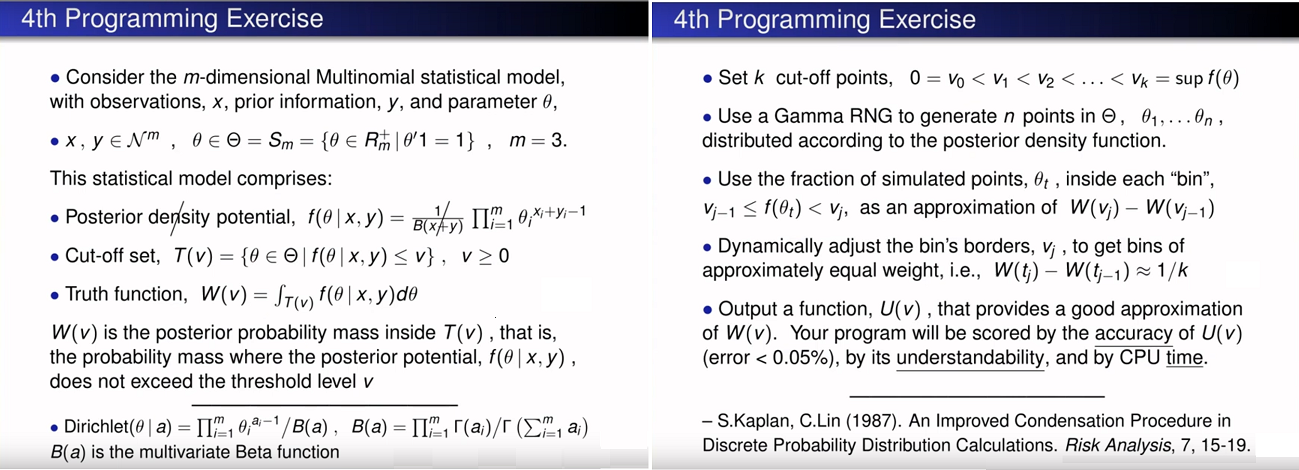

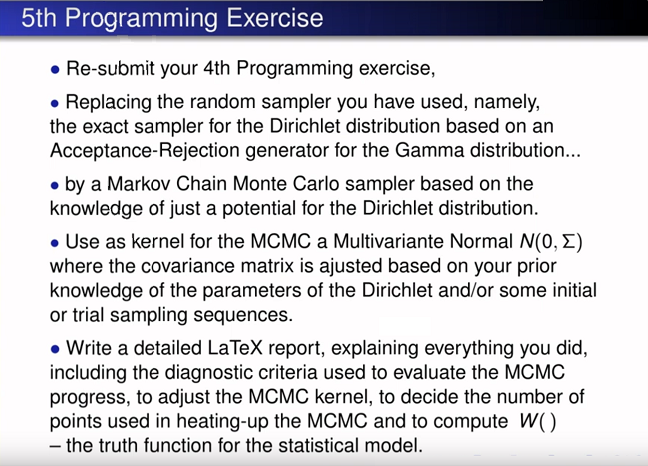

In [1]:
#Bibliotecas
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

In [229]:
#INFO da dupla
INFO = {5381328:"Nikolas Lukin",11811012:"Vinícius Collaço"}

class Estimador:
  """
  Classe para criar o objeto, ele recebe valores para os vetores x e y.
  Os metodos definidos abaixo serao utilizadas por um corretor automatico. 
  Portanto, precisa manter os outputs e inputs dos 2 metodos abaixo. 
  """
  def __init__(self,x,y):
    """
    Inicializador do objeto. Este metodo recebe 
    valores pros vetores x e y em formato de lista 
    e implementa no objeto. 
    """
    
    self.vetor_x = np.array(x) #formato: [0,0,0] - List cujo len(x) = 3
    self.vetor_y = np.array(y) #formato: [0,0,0] - List cujo len(y) = 3

    self.alpha = self.vetor_x + self.vetor_y
    self.n = 2000000 #Definido no relatorio
    self.queima = 1000
    self.k = 4000 #Numero de bins definido no relatorio

    #calcula a constante de normalização
    beta = (np.prod(gamma(self.alpha))) / (gamma(sum(self.alpha)))
    self.const_norm = 1/beta

    self.covariancia = self.matriz_de_covariancia()   
    self.M_cov_reduzida = self.covariancia[:2, :2]

    self.potenciais = self.amostra_MCMC(self.vetor_x, self.vetor_y, self.n)
    self.f_ordenada = self.f_norm_ord()
    self.f_min = self.f_ordenada[0]
    self.f_max = self.f_ordenada[-1]
    self.f_bins = self.f_bins()

  def matriz_de_covariancia(self):
    """
    Funcao que gera a matriz de covariancia sigma, 
    com base na variancia e covariancia da 
    https://en.wikipedia.org/wiki/Dirichlet_distribution
    """
    size = len(self.alpha)
    M_sigma = np.identity(size)
    a_0 = sum(self.alpha)
      
    for i in range(size):
      for j in range(size):
        if i == j:#Variancia da Dirichilet            
          M_sigma[i][j] = (a_0 - self.alpha[i])*self.alpha[i]/((a_0**2)*(a_0 + 1))            
        else:#Covariancia da Dirichilet
          M_sigma[i][j] = -1*self.alpha[i]*self.alpha[j]/((a_0**2)*(a_0 + 1))   
    
    return M_sigma

  def gera_candidato(self, atual):
    """metodo para gerar um ponto candidato no simplex"""
    while True:
      passo = np.random.multivariate_normal([0, 0], self.M_cov_reduzida)
      candidato = ([atual[0] + passo[0],
                    atual[1] + passo[1],
                    1 - (atual[0] + passo[0] + atual[1] + passo[1])]
                  )
      if all(i > 0 for i in candidato) > 0:
        return candidato
  
  def f_theta(self,theta):
    """metodo para calcular o potencial de f(theta)"""
    f = np.prod(np.power(theta, self.alpha - 1))
    return f
  
  def amostra_MCMC(self, x, y, n):
    """
    Funcao que recebe valores pros vetores x e y, o tamanho n da amostra, 
    gera uma amostra de tamanho n a partir do metodo de monte carlo via 
    cadeias de markov, onde cada elemento da amostra tem tamanho 3 (vetor),
    e retorna uma lista de tamanho n com os potenciais de cada ponto obtido,
    onde cada elemento tem tamanho 1 (escalar).
    
    Nao utilize a fuancao densidade de probabilidade, apenas a funcao potencial!
    """
    amostras = [[1/3, 1/3, 1/3]] #ponto inicial, centro do simplex
    alpha = np.array(x) + np.array(y)

    for _ in range(n + self.queima):
      candidato = self.gera_candidato(amostras[-1])

      #probabilidade de aceitacao
      prob = min(1, self.f_theta(candidato) / self.f_theta(amostras[-1]))

      #aceita com a probabilidade calculada
      if np.random.random() < prob:
        amostras.append(candidato)  
      else:
        amostras.append(amostras[-1])

    amostra_de_potenciais = np.prod(np.power(np.array(amostras), alpha - 1), axis=1)
    return amostra_de_potenciais[self.queima+1:] # Exemplo do formato = [0.04867, 0.00236, 0.00014 ... ]

  def f_norm_ord(self):
    """metodo para normalizar e ordenar a potencial gerada da cadeia de Markov"""
    f = self.potenciais
    f.sort()
    f_normalizada = f*self.const_norm

    return f_normalizada
  
  def f_bins(self):
    """metodo para separar a f em bins"""

    f_normalizada = self.f_ordenada
    f_bins = [0]*self.k

    #Separa em bins com uma quantidade constante de pontos cada bin
    passo = int(self.n/self.k)

    for i in range (0,self.k):
      f_bins[i] = f_normalizada[i*passo]

    return f_bins
  
  def U(self,v):
    """
    Este metodo recebe um valor para v e, a partir dele, retorna U(v|x,y) 
    a partir dos vetores x e y inicializados anteriormente
    """
    f_ordenado = self.f_bins

    if v > self.f_max:
      return 1
    if v < self.f_min:
      return 0  

    # numero de bins abaixo de um certo v
    menor_que_v = np.searchsorted(f_ordenado, v, side='left')
    u = menor_que_v/self.k

    return u    

Segue um exemplo de funcionamento:
x = [4, 6, 4] e y = [1, 2, 3]
U( 0 ) =  0
U( 1 ) =  0.037
U( 2 ) =  0.083
U( 3 ) =  0.1345
U( 4 ) =  0.18875
U( 5 ) =  0.24575
U( 6 ) =  0.30425
U( 7 ) =  0.3645
U( 8 ) =  0.426
U( 9 ) =  0.489
U( 10 ) =  0.5535
U( 11 ) =  0.6185
U( 12 ) =  0.68475
U( 13 ) =  0.7515
U( 14 ) =  0.81925
U( 15 ) =  0.888
U( 16 ) =  0.9575
U( 17 ) =  1
Este exemmplo foi feito para demonstrar o funcionamento esperado do objeto


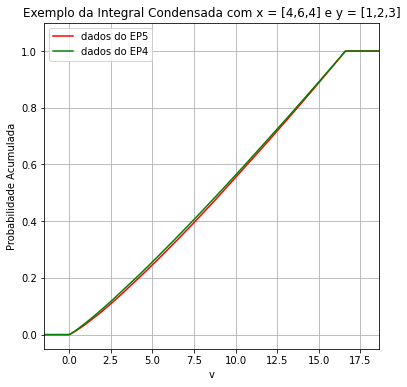

In [231]:
def main():
    #Coloque seus testes aqui
    x = [4, 6, 4]
    y = [1, 2, 3]
    estimativa = Estimador(x,y) 
    print("Segue um exemplo de funcionamento:")
    print("x =",x,"e y =",y)
    for i in range (int(estimativa.f_max + 2)):
      print("U(",i,") = ", estimativa.U(i))
    print("Este exemmplo foi feito para demonstrar o funcionamento esperado do objeto")

    #Plotando U(v)
    v = np.arange (-2,estimativa.f_max+3,0.05)
    probabilidade_acumulada = [estimativa.U(i) for i in v]
    
    dados_ep4 = np.loadtxt('https://raw.githubusercontent.com/Batovs/MAP2110---Projeto-6---Caos/main/prob_acumulada_ep4.csv')
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(v,probabilidade_acumulada,color='r',label='dados do EP5')
    ax.plot(v,dados_ep4, color ='g', label='dados do EP4')
    ax.set(xlabel='v', ylabel='Probabilidade Acumulada',
           title='Exemplo da Integral Condensada com x = [4,6,4] e y = [1,2,3]')
    plt.axis([-1.5, estimativa.f_max+2, -0.05, 1.1])

    ax.legend() 
    ax.grid()
    plt.show()
    fig.savefig('Integral.png')

if __name__ == "__main__":
    main()

In [218]:
"""
Trecho abaixo sem muita utilidade prática, 
só para deixar as funções e saídas no padrão exigido
e jogar a PEP8 na casa do chapéu
"""

def gera_candidato(atual, M_sigma):
  """metodo para gerar um ponto candidato no simplex"""
  M_cov_reduzida = M_sigma[:2, :2]
  while True:
    passo = np.random.multivariate_normal([0, 0], M_cov_reduzida)
    candidato = ([atual[0] + passo[0],
                  atual[1] + passo[1],
                  1 - (atual[0] + passo[0] + atual[1] + passo[1])]
                )
    if all(i > 0 for i in candidato) > 0:
      return candidato

def f_theta(theta, alpha):
  """metodo para calcular o potencial de f(theta)"""
  f = np.prod(np.power(theta, alpha - 1))
  return f

def amostra_MCMC(x, y, n):
  """
  Funcao que recebe valores pros vetores x e y, o tamanho n da amostra, 
  gera uma amostra de tamanho n a partir do metodo de monte carlo via 
  cadeias de markov, onde cada elemento da amostra tem tamanho 3 (vetor),
  e retorna uma lista de tamanho n com os potenciais de cada ponto obtido,
  onde cada elemento tem tamanho 1 (escalar).
  
  Nao utilize a fuancao densidade de probabilidade, apenas a funcao potencial!
  """

  queima = 1000

  alpha = np.array(x) + np.array(y)
  size = len(alpha)
  M_sigma = np.identity(size)
  a_0 = sum(alpha)
    
  for i in range(size):
    for j in range(size):
      if i == j:#Variancia da Dirichilet            
        M_sigma[i][j] = (a_0 - alpha[i])*alpha[i]/((a_0**2)*(a_0 + 1))            
      else:#Covariancia da Dirichilet
        M_sigma[i][j] = -1*alpha[i]*alpha[j]/((a_0**2)*(a_0 + 1))   
  
  
  amostras = [[1/3, 1/3, 1/3]] #ponto inicial, centro do simplex
  

  for _ in range(n + queima):
    candidato = gera_candidato(amostras[-1], M_sigma)

    #probabilidade de aceitacao
    prob = min(1, f_theta(candidato,alpha) / f_theta(amostras[-1],alpha))

    #aceita com a probabilidade calculada
    if np.random.random() < prob:
      amostras.append(candidato)  
    else:
      amostras.append(amostras[-1])

  amostra_de_potenciais = np.prod(np.power(np.array(amostras), alpha - 1), axis=1)
  return list(amostra_de_potenciais[queima+1:]) # Exemplo do formato = [0.04867, 0.00236, 0.00014 ... ]